In [1]:
import cv2
import numpy as np
import pylab
import random
import math
import pickle
import glob
import os
import pytesseract
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from src.detector.color_model_filter import *

In [2]:
#im = cv2.imread("data/006.jpg")
#file = "data/{:03d}.jpg".format(random.randint(1,404))
file = "data/219.jpg"
print(file)
im = cv2.imread(file)
im = im[30:, :, :]
im = cv2.resize(im, (1224,1024))

data/219.jpg


In [3]:

#im = cv2.GaussianBlur(im, (15, 15), 0)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)

bn_im = im
bn = np.zeros_like(bn_im)
for i in range(bn_im.shape[2]):
    min_val = bn_im[:, :, i].min()
    max_val = bn_im[:, :, i].max()
    bn[:, :, i] = (bn_im[:, :, i] - min_val) * (255 / (max_val - min_val))
    #pylab.imshow(np.concatenate([bn[:,:,i], bn_im[:, :, i]], axis=1), cmap=pylab.gray())
    #pylab.show()
    #print(bn[:, :, i].max(), bn[:, :, i].min())
#pylab.imshow(np.concatenate([bn, bn_im], axis=1), cmap=pylab.gray())
#pylab.show()


im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
print(im_hsv[:, :, 1].max(), im_hsv[:, :, 1].min())

(1024, 1224, 3)
205 0


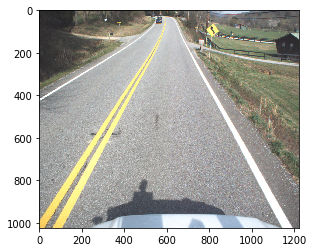

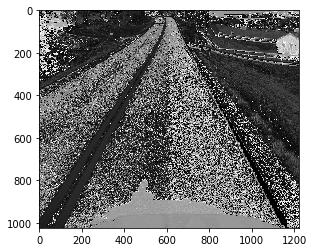

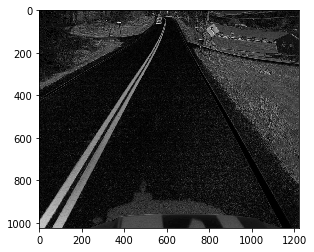

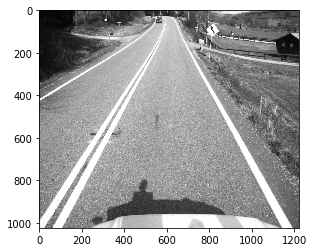

In [4]:
pylab.imshow(im_rgb)
pylab.show()
pylab.imshow(im_hsv[:,:,0], cmap=pylab.gray())
pylab.show()
pylab.imshow(im_hsv[:,:,1], cmap=pylab.gray())
pylab.show()
pylab.imshow(im_hsv[:,:,2], cmap=pylab.gray())
pylab.show()

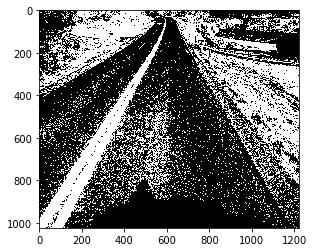

True

In [5]:
hue = im_hsv[:, :, 0]
hue = cv2.GaussianBlur(im_hsv[:, :, 0], (3,3), 0)
hue_mask = (hue < 40) & (hue > 10)
pylab.imshow(hue_mask, cmap=pylab.gray())
pylab.show()
cv2.imwrite("mask_hue.png", hue_mask * 255)

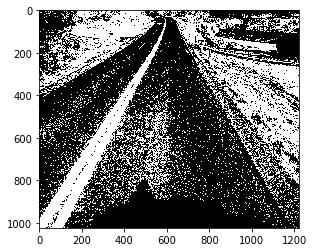

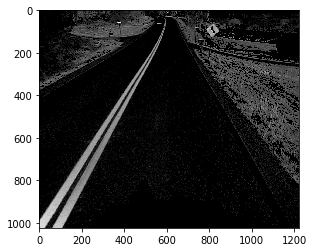

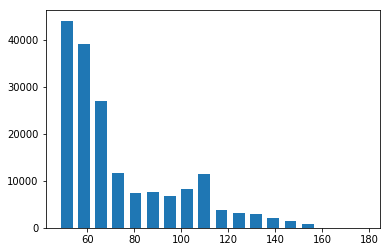

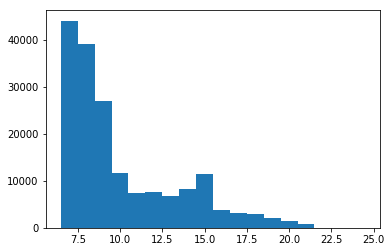

correct threshold: 10991
12 7655 7289
14 8322 6689
histogram threshold: 99.0 151.0 95.16
201.87124609512867


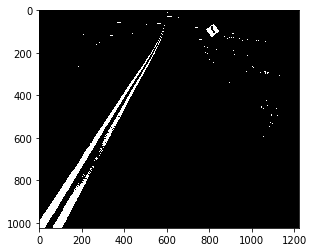

In [6]:
def generate_raw_mask(hsv_image: np.ndarray):
    hue = cv2.GaussianBlur(hsv_image[:, :, 0], (3, 3), 0)
    hue_mask = (hue < 40) & (hue > 10)
    
    pylab.imshow(hue_mask, cmap=pylab.gray())
    pylab.show()
    cv2.imwrite("mask_hue.png", hue_mask * 255)
    
    yellow_saturation = cv2.GaussianBlur(hsv_image[:, :, 1], (3, 3), 0)
    yellow_saturation = yellow_saturation * hue_mask
    # define saturation threshold using value histogram
    smin, smax = np.percentile(yellow_saturation, [97, 99.87])
    hist, col = np.histogram(yellow_saturation, 25)
    correct_threshold = int(hue_mask.sum() * 0.025)
    
    pylab.imshow(yellow_saturation, cmap=pylab.gray())
    pylab.show()
    plt.bar(col[7:-1], hist[7:], 5)
    # plt.yscale('log')
    plt.show()
    plt.bar(range(7, len(hist)), hist[7:], 1)
    # plt.yscale('log')
    plt.show()
    print("correct threshold: {}".format(correct_threshold))
    
    last_v = correct_threshold
    last_convex_index = None
    was_increasing = False
    for i, v in enumerate(hist):
        if i < 8:
            continue
        if col[i] > smax and (smax > 100 or v < 50):
            break
        # if variation goes from decreasing to increasing keep index
        if v >= last_v and hist[i] < correct_threshold:
            if not was_increasing:
                last_convex_index = i
            print(last_convex_index, v, last_v)
            was_increasing = True
        elif v < 0.95 * last_v:
            was_increasing = False
        last_v = v

    # if no curve inversion found fall back to the old fashioned percentile method
    if last_convex_index is None:
        threshold = int(0.6 * (smax - smin) + smin)
        print("percentile threshold", smin, smax, threshold, yellow_saturation.max())
    else:
        if col[last_convex_index - 2] > smin:
            last_convex_index -= 3
        else:
            last_convex_index -= 1
        threshold = col[last_convex_index]
        print("histogram threshold:", smin, smax, col[last_convex_index])
    
    print(np.sqrt(np.sum(hist[last_convex_index:])))
    #threshold = 96.6
    return (yellow_saturation > threshold).astype(np.uint8)

mask = generate_raw_mask(im_hsv)

pylab.imshow(mask, cmap=pylab.gray())
pylab.show()

In [7]:
#yellow_saturation = yellow_saturation * (1 - mask)
#pylab.imshow(yellow_saturation, cmap=pylab.gray())
#pylab.show()

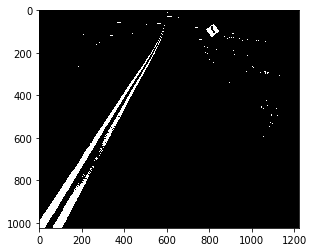

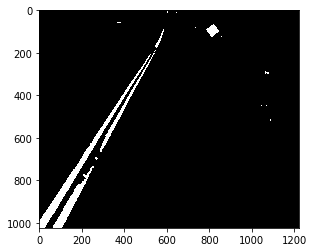

True

In [8]:

pylab.imshow(mask, cmap=pylab.gray())
pylab.show()
cv2.imwrite("masknf.png", mask  * 255 )

mask = filter_mask_noise(mask)

pylab.imshow(mask, cmap=pylab.gray())
pylab.show()
cv2.imwrite("maskf.png", mask  * 255 )

In [9]:
#for_edges = im_hsv[:, :, 2].copy()
#for_edges = cv2.GaussianBlur(for_edges, (3,3), 0)
#edges = cv2.Canny(for_edges, 75, 150)
#edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))) # close sign
#cv2.imwrite("edges.png", edges)
#cv2.imwrite("edges_masked.png", edges * mask)
#pylab.imshow(edges, cmap=pylab.gray())
#pylab.show()

17


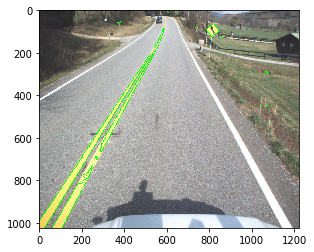

True

In [10]:
_, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imc = cv2.drawContours(im_rgb.copy(), contours, -1, (0,255,0), 2)
print(len(contours))
pylab.imshow(imc)
pylab.show()
cv2.imwrite("contours.png", cv2.cvtColor(imc, cv2.COLOR_RGB2BGR))

2
4
6
6
6
4
2
6
2
4
6
2
6
4
5
6
6


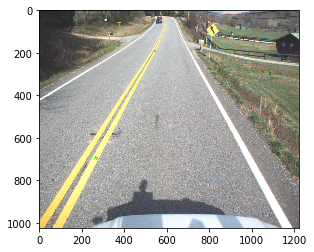

32 1
37 1
14 1
0


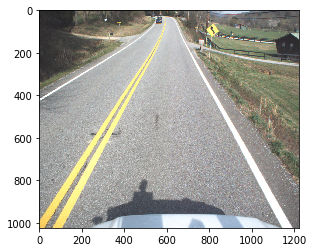

In [11]:
triangle_list = []
triangle_full_contour_list = []
non_triangle_list = []
for c in contours:
    approx_c = cv2.approxPolyDP(c,0.05 * cv2.arcLength(c, True), True)
    print(len(approx_c))
    if len(approx_c) == 3 or (len(approx_c) == 4 and cv2.arcLength(approx_c, True) < 100):
        triangle_list.append(approx_c)
        triangle_full_contour_list.append(c)
    else:
        non_triangle_list.append(c)

triangle_contours_im = cv2.drawContours(im_rgb.copy(), triangle_list, -1, (0,255,0), 2)
pylab.imshow(triangle_contours_im)
pylab.show()
cv2.imwrite("triangles.png", cv2.cvtColor(triangle_contours_im, cv2.COLOR_RGB2BGR))

triangle_dsc = []
for i, t in enumerate(triangle_list):
    triangle_dsc.append({'center': np.mean(t, axis=0),
                         'size': cv2.arcLength(t, True),
                         'triangle_id': i})

arrow_sign_contours = []
matched_ids = []
for desc in triangle_dsc:
    if desc['triangle_id'] in matched_ids:
        continue
    center = desc['center']
    shearch_radius = int(desc['size'] * 0.7)
    matches = []
    for other_desc in triangle_dsc:
        if np.linalg.norm(center - other_desc['center']) < shearch_radius:
            if other_desc['size'] < 3 * desc['size'] and other_desc['size'] * 3 > desc['size']:
                matches.append(other_desc['triangle_id'])
    print(shearch_radius, len(matches))
    if len(matches) == 3:
        all_pts = np.concatenate([triangle_list[m] for m in matches], axis=0)
        sign_contour = cv2.convexHull(all_pts)
        arrow_sign_contours.append(sign_contour)
        matched_ids += matches

print(len(arrow_sign_contours))
triangle_contours_merged_im = cv2.drawContours(im_rgb.copy(), arrow_sign_contours, -1, (0,255,0), 2)
pylab.imshow(triangle_contours_merged_im)
pylab.show()
cv2.imwrite("triangles_merged.png", cv2.cvtColor(triangle_contours_merged_im, cv2.COLOR_RGB2BGR))

not_matched_list = []
for i, c in enumerate(triangle_full_contour_list):
    if i not in matched_ids:
        not_matched_list.append(c)

contours = arrow_sign_contours + non_triangle_list + not_matched_list

Perimeter: 855.1341168880463
Bounding box: ((165.84609985351562, 880.769287109375), (348.0414123535156, 40.68339157104492), -60.2551155090332)
Perimeter: 29.071067690849304
Perimeter: 19.071067690849304
Perimeter: 13.656854152679443
Perimeter: 2093.443976998329
Bounding box: ((266.69561767578125, 622.259521484375), (962.7380981445312, 39.97721481323242), -56.571258544921875)
Perimeter: 13.656854152679443
Perimeter: 1177.7930589914322
Bounding box: ((408.78515625, 429.69305419921875), (528.213623046875, 23.091814041137695), -61.70795822143555)
Perimeter: 19.656854152679443
Perimeter: 227.37972366809845
Bounding box: ((570.0672607421875, 133.03285217285156), (97.59081268310547, 12.66690731048584), -63.98321533203125)
Perimeter: 17.071067690849304
Perimeter: 182.10764503479004
Bounding box: ((816.5732421875, 94.3414306640625), (46.071258544921875, 46.5397834777832), -38.65980911254883)
Area: 1922.0 area ratio: 0.8963940160444922
Ratio: 1.0784077256801863
height ratio: 2.2663891779396463
O

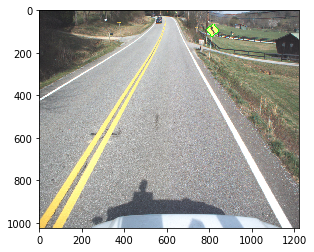

True

In [12]:
contours_threshold = {'min_per': 70,
                      'width_ratio': 3.0,
                      'bounding_rect_area_max_ratio': 0.5,
                      'max_squareness': 3.0,
                      'max_height_ratio': 170}

strict_contours_threshold = {'min_per': 50,
                             'width_ratio': 5.0,
                             'bounding_rect_area_max_ratio': 0.7,
                             'max_squareness': 1.5,
                             'max_height_ratio': 200}

def can_contour_be_sign(c, strict: bool=False):
    if not strict:
        param = contours_threshold
    else:
        param = strict_contours_threshold
    per = cv2.arcLength(c,True)
    print("Perimeter:", per)
    if per < param['min_per']:
        return False
    bounding_box = cv2.minAreaRect(c)
    print("Bounding box:",bounding_box)
    if bounding_box[1][0] > param['width_ratio'] * bounding_box[1][1]:
        return False
    a = cv2.contourArea(c)
    print("Area:", a, 'area ratio:', a / (bounding_box[1][0] * bounding_box[1][1]))
    if a < param['bounding_rect_area_max_ratio'] * bounding_box[1][0] * bounding_box[1][1]:
        return False
    ratio = per**2 / (16 * a)
    print("Ratio:", ratio)
    if ratio > param['max_squareness']:
        return False
    height = np.min(c.reshape((-1, 2)), axis=0)[1]
    h_ratio = height**2 / a
    print("height ratio:", h_ratio)
    if h_ratio > param['max_height_ratio']:
        return False
    print("OK")
    return True
filtered_contours = list(filter(can_contour_be_sign, contours))
#filtered_contours = list(map(cv2.convexHull, filtered_contours))

print("{} contours left".format(len(filtered_contours)))
imcf = cv2.drawContours(im_rgb.copy(), filtered_contours, -1, (0,255,0), 2)
pylab.imshow(imcf)
pylab.show()
cv2.imwrite("contoursf.png", cv2.cvtColor(imcf, cv2.COLOR_RGB2BGR))

In [13]:
TWO_PI = 2.0 * math.pi

def get_not_convex_point(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    # Check for too few points
    if len(polygon) < 3:
        raise ValueError
    # Get starting information
    old_x, old_y = polygon[-2]
    new_x, new_y = polygon[-1]
    new_direction = math.atan2(new_y - old_y, new_x - old_x)
    angle_sum = 0.0
    pos_angle_list = []
    neg_angle_list = []
    # Check each point (the side ending there, its angle) and accum. angles
    for ndx, newpoint in enumerate(polygon):
        # Update point coordinates and side directions, check side length
        old_x, old_y, old_direction = new_x, new_y, new_direction
        new_x, new_y = newpoint
        new_direction = math.atan2(new_y - old_y, new_x - old_x)
        if old_x == new_x and old_y == new_y:
            raise ValueError  # repeated consecutive points
        # Calculate & check the normalized direction-change angle
        angle = new_direction - old_direction
        if angle <= -math.pi:
            angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
        elif angle > math.pi:
            angle -= TWO_PI
        if angle < 0.0:
            neg_angle_list.append(ndx - 1)
        else:
            pos_angle_list.append(ndx - 1)
        # Accumulate the direction-change angle
        angle_sum += angle
    if len(pos_angle_list) < len(neg_angle_list):
        return pos_angle_list, neg_angle_list
    else:
        return neg_angle_list, pos_angle_list
    
def split_signs(contour, non_convex_points):
    if 2 < len(non_convex_points) <= 4:
        min_dist = 8000
        clossest_points = None
        for i, p1 in enumerate(non_convex_points):
            for p2 in non_convex_points[i+1:]:
                dist = np.linalg.norm(contour[p1] - contour[p2], 2)
                if min_dist > dist and len(contour) - 3 > abs(p1 - p2) > 3:
                    min_dist = dist
                    clossest_points = [p1, p2]
        # if the convex points are to close to each other, it's probably false positive
        if clossest_points is None:
            return []
        non_convex_points = clossest_points
    elif len(non_convex_points) != 2:
        print("Contour with not exactly 2 non convex point ({} points) are not handled yet...".format(len(non_convex_points)))
        return []
    convex_contour_list = []
    poly_1 = np.concatenate([contour[:non_convex_points[0] + 1], contour[non_convex_points[-1]:]], axis=0)
    convex_contour_list.append(poly_1)
    poly_2 = contour[non_convex_points[0]:non_convex_points[-1] + 1]
    convex_contour_list.append(poly_2)
    return convex_contour_list

def try_to_split_signs(contour):
    shaped_contour = contour.reshape((-1, 2))
    non_convex_points, convex_point = get_not_convex_point(shaped_contour.copy())
    if len(non_convex_points) == 1:
        return [shaped_contour[convex_point]]
    else:
        return split_signs(shaped_contour.copy(), non_convex_points)
            
            

approx 4
rect acuracy: 1.064230543970988
approx acuracy: 0.9068678459937565 (len: 4)
Perimeter: 167.03923416137695
Bounding box: ((817.6755981445312, 95.7386703491211), (42.20188903808594, 42.79428482055664), -36.32682418823242)
Area: 1743.0 area ratio: 0.9651164610517337
Ratio: 1.0005057999576636
height ratio: 2.4991394148020656
OK


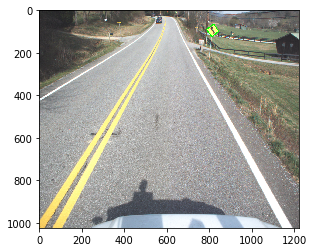

1 contours left


In [14]:
def approximate_contours(contour_list, block_recution=False):
    approx_contours = []
    for c in contour_list:
        if len(c) == 0:
            continue
        approx_c = cv2.approxPolyDP(c,0.017 * cv2.arcLength(c, True), True)
        print('approx', len(approx_c))
        #approx_contours.append(approx_c)
        #if 3 <= len(approx_c) <= 5:
        #    approx_c = cv2.approxPolyDP(c,0.065 * cv2.arcLength(c, True), True)
        #    if len(approx_c) == 3:
        #        center = np.mean(approx_c, axis=0)
        #        print(center)
        if 4 <= len(approx_c) < 8:
            # convert to a convex polynome
            cc = cv2.convexHull(c)
            # approximate by reducing the number of line in polygone
            approx_cc = cv2.approxPolyDP(cc,0.065 * cv2.arcLength(cc, True), True)
            # approximate by taking the smallest possible rect enclosing the polygone
            rect = cv2.minAreaRect(approx_c)
            # choose the one that have the best accuracy
            rect_area = rect[1][0] * rect[1][1]
            approx_cc_area = cv2.contourArea(approx_cc)
            c_area = cv2.contourArea(c)
            rect_acuracy = c_area / rect_area
            approx_accuracy = approx_cc_area / c_area
            print("rect acuracy:", rect_acuracy)
            print("approx acuracy: {} (len: {})".format(approx_accuracy, len(approx_cc)))
            if len(approx_cc) == 4 and ((approx_accuracy > 0.8 and not block_recution) or approx_accuracy > 0.9):
                approx_contours.append(approx_cc)
                continue
            elif rect_acuracy > 0.7:
                m = cv2.moments(c)
                center = int(m['m10']/m['m00']), int(m['m01']/m['m00'])
                rect = (center, (rect[1][0] * 1, rect[1][1] * 1), rect[2])
                box = cv2.boxPoints(rect)
                box = np.int0(box).reshape((4, 1, 2))
                approx_contours.append(box)
                continue
        if 6 < len(approx_c) < 14 and not block_recution:
            #probably two sign merged in one...
            splitted_contours = try_to_split_signs(approx_c)
            approx_contours += approximate_contours(splitted_contours, True)
    return approx_contours

aprox_cnt = approximate_contours(filtered_contours)
aprox_cnt = list(filter(lambda x: can_contour_be_sign(x, strict=True), aprox_cnt))

imacf = cv2.drawContours(im_rgb.copy(), aprox_cnt, -1, (0,255,0), 3)
pylab.imshow(imacf)
pylab.show()
cv2.imwrite("contoursfa.png", cv2.cvtColor(imacf, cv2.COLOR_RGB2BGR))

print("{} contours left".format(len(aprox_cnt)))

[[846.  99.]
 [814. 125.]
 [788.  91.]
 [822.  66.]]


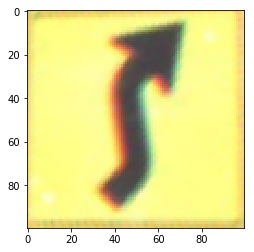

In [15]:
BOX_SIZE = 100
pts_dst_anti_horaire = np.float32([[0, BOX_SIZE], [BOX_SIZE, BOX_SIZE], [BOX_SIZE, 0], [0, 0]])
pts_dst_horaire = np.float32([[0, BOX_SIZE], [0, 0], [BOX_SIZE, 0], [BOX_SIZE, BOX_SIZE]])
signs_img = []
for c in aprox_cnt:
    if len(c) == 4:
        pts_src = np.array(c, dtype=np.float32).reshape((4, 2))
        print(pts_src)
        # ensure rotation is the same for every sign
        right_angle, bottom_angle = np.argmax(pts_src, axis=0)
        diff_to_bottom = pts_src - pts_src[bottom_angle]
        bottom_threshold = (pts_src[bottom_angle][1] - np.min(pts_src[:,1])) * 0.2
        mask_bt_corner = diff_to_bottom[:, 1] < -bottom_threshold
        if mask_bt_corner.sum() < 3:  # if two corner are near the bottom we only take the left most one
            masked_corner = pts_src.copy()
            masked_corner[mask_bt_corner, :] = 8000  # mask out the others corner
            sorted_arg = np.argsort(masked_corner[:, 0])  # get the position of each corner sorted by x value
            bottom_angle = sorted_arg[0]
            right_angle = sorted_arg[1]
        pts_src = np.concatenate([pts_src[bottom_angle:], pts_src[:bottom_angle]])
        if right_angle == bottom_angle + 1:
            pts_dst = pts_dst_anti_horaire
        else:
            pts_dst = pts_dst_horaire
        # extract the sign
        transform_matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        sign = cv2.warpPerspective(im_rgb, transform_matrix, (BOX_SIZE, BOX_SIZE))
        signs_img.append(sign)
        pylab.imshow(sign)
        pylab.show()

In [16]:
#with open('sign_orb_descriptor.pikle', 'rb') as handle:
#    sign_template = pickle.load(handle)
#
#def tuple_to_kp(t):
#    return cv2.KeyPoint(x=t[0][0], y=t[0][1], _size=t[1], _angle=t[2], _response=t[3], _octave=t[4])
#    
#for template in sign_template:
#    template["kp"] = list(map(tuple_to_kp , template['keypoints']))
#
#orb = cv2.ORB_create()
#matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#GOOD_MATCH_PERCENT = 0.8
#for sign in signs_img:
#    kp = orb.detect(sign,None)
#    kp, des = orb.compute(sign, kp)
#    for template in sign_template:
#        # Match features.
#        matches = matcher.match(des, template['descriptor'], None)
#        print(len(matches))
#        if len(matches) == 0:
#            continue
#
#        # Sort matches by score
#        matches.sort(key=lambda x: x.distance, reverse=False)
#
#        # Remove not so good matches
#        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
#        matches = matches[:numGoodMatches]
#
#        # Draw top matches
#        template_image = cv2.cvtColor(cv2.imread(template['file']), cv2.COLOR_BGR2RGB)
#        
#        # Extract location of good matches
#        points1 = np.zeros((len(matches), 2), dtype=np.float32)
#        points2 = np.zeros((len(matches), 2), dtype=np.float32)
#        
#        for i, match in enumerate(matches):
#            points1[i, :] = kp[match.queryIdx].pt
#            points2[i, :] = template['kp'][match.trainIdx].pt
#            
#        # Find homography
#        h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
#        matchesMask = mask.ravel().tolist()
#        
#        print(mask.sum())
#        
#        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                   singlePointColor = None,
#                   matchesMask = matchesMask, # draw only inliers
#                   flags = 2)
#        
#        imMatches = cv2.drawMatches(sign, kp, template_image, template['kp'], matches, None, **draw_params)
#        pylab.imshow(imMatches)
#        pylab.show()

matching sign:


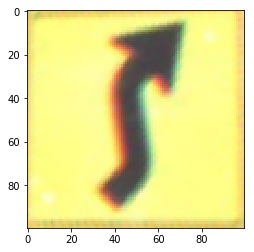

70 255 235.6 0.2172


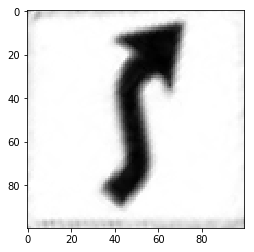

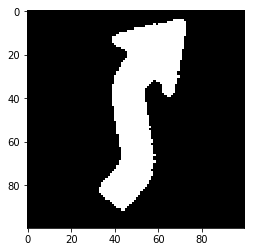

ocr: Sign


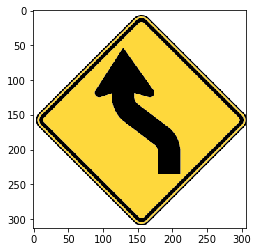

score: 0.9245810055865922


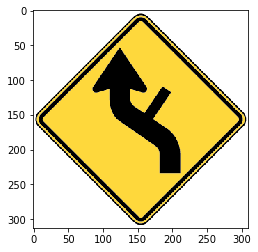

score: 0.8646362098138748


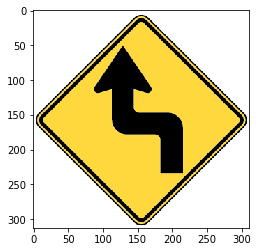

score: 0.8415614236509759


In [17]:
def template_iterator(path: str):
    files_list = glob.glob(os.path.join(path, "*sng*.png"))
    size_factors = [0.8, 0.9, 0.95]
    for t in files_list:
        template = cv2.imread(t, cv2.IMREAD_UNCHANGED)
        template = template[:, :, 3] == 255
        for s in size_factors:
            resize_ratio = BOX_SIZE * s / max(template.shape)
            tem = cv2.resize(template.astype(np.uint8), (0,0), fx=resize_ratio, fy=resize_ratio)
            yield t[:-11], tem

def diamond_template_generator(sign_dir: str):
    for name, t in template_iterator(os.path.join(sign_dir, "diamond")):
        yield name, t, False
        yield name, np.flip(np.rot90(t), axis=1), True
    for name, t in template_iterator(os.path.join(sign_dir, "diamond", "no_mirror")):
        yield name, t, False

def other_template_generator(sign_dir: str):
    for name, t in template_iterator(os.path.join(sign_dir, "others")):
        s = max(t.shape)
        t = cv2.resize(t, (s,s))
        yield name, t, False
        yield name, np.flip(t, axis=1), True
    for name, t in template_iterator(os.path.join(sign_dir, "others", "no_mirror")):
        # resize to a square as the sign are transformed that way
        s = max(t.shape)
        t = cv2.resize(t, (s, s))
        yield name, t, False
        
def template_generator(sign_path):
    for name, t, flipped in diamond_template_generator(sign_path):
        yield name, t, flipped
    for name, t, flipped in other_template_generator(sign_path):
        yield name, t, flipped

def speed_sign_creator(speed: int, path_to_base_sign="sign/speed_limit/W13-1P_out-01.png"):
    ss = cv2.imread(path_to_base_sign)
    ss = cv2.putText(ss, "{:02d}".format(speed), (40, 135), cv2.FONT_HERSHEY_SIMPLEX, 4.0, 0, 15)
    return ss
        
#for t in template_generator(templates_files):
#    print(t.shape)
#    pylab.imshow(t, cmap=pylab.gray())
#    pylab.show()

speed_regex = re.compile("[0-9][0-9]", re.MULTILINE)

for s, sign in enumerate(signs_img):
    print("matching sign:")
    pylab.imshow(sign)
    pylab.show()
    hsv_sign = cv2.cvtColor(sign, cv2.COLOR_RGB2HSV)
    threshold_factor = 0.8
    #v_min = hsv_sign[:, :, 2].min()
    #v_max = hsv_sign[:, :, 2].max()
    v_max, v_min = np.percentile(hsv_sign[:, :, 2], [20, 60])
    threshold = v_max * threshold_factor + v_min * (1.0 - threshold_factor)
    mask = (hsv_sign[:, :, 2] < threshold).astype(np.uint8)
    print(hsv_sign[:, :, 2].min(), hsv_sign[:, :, 2].max(), threshold, np.sum(mask) / (BOX_SIZE**2))
    pylab.imshow(hsv_sign[:, :, 2], cmap=pylab.gray())
    pylab.show()
    #pylab.imshow(mask, cmap=pylab.gray())
    #pylab.show()
    # Canny mask
    #mask = cv2.Canny(sign, 50, 75)
    #pylab.imshow(mask, cmap=pylab.gray())
    #pylab.show()
    #close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    #open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel)  # close sign
    #pylab.imshow(mask, cmap=pylab.gray())
    #pylab.show()
    # compute contours to (try to) only extract the sign pictogram
    _, s_contours, c_hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    #print(c_hierarchy)
    signc = cv2.drawContours(sign.copy(), s_contours, -1, (0,255,0), -1)
    #pylab.imshow(signc)
    #pylab.show()
    # extract biggest area contour as the pictogram
    threshold = BOX_SIZE // 5
    #mask = np.zeros_like(mask)
    for i, c in enumerate(s_contours):
        c_centered_coord = (c > threshold) * (c < (BOX_SIZE - threshold))
        if np.sum(np.multiply(c_centered_coord[:, :, 0], c_centered_coord[:, :, 1])) == 0:
            ### if at least one border point is in the center, then draw the area
            # if no border point is in the center, then remove the area
            if cv2.contourArea(c) > 0.75 * BOX_SIZE**2:
                # if th area cover the entire image, we probalby have the sign boundary, 
                # here we just remove some pixels around he contour
                mask = cv2.drawContours(mask, [c], -1, 0, 5)
            else:
                mask = cv2.drawContours(mask, [c], -1, 0, -1)
            #child = c_hierarchy[0, i, 2]
            #if child != -1:
            #    parent_area = cv2.contourArea(c)
            #    while child != -1:
            #        child_contour = s_contours[child]
            #        # if child area is not too small draw it in black
            #        print("parent {}, child {}, ap {}, ac {}".format(i, child, parent_area, cv2.contourArea(child_contour)))
            #        if cv2.contourArea(child_contour) > 0.2 * parent_area:
            #             mask = cv2.drawContours(mask, [child_contour], -1, 0, -1)
            #        # go to next child
            #        child = c_hierarchy[0, child, 0]
            
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, open_kernel)  # open sign
    pylab.imshow(mask, cmap=pylab.gray())
    pylab.show()
    mask_size = np.sum(mask)
    # OCR
    ocr_img = np.ones((BOX_SIZE * 2, BOX_SIZE * 2), dtype=np.uint8) * 255
    ocr_img[BOX_SIZE//2:BOX_SIZE+BOX_SIZE//2, BOX_SIZE//2:BOX_SIZE+BOX_SIZE//2] = 255 - mask * 255
    ocr_img = cv2.putText(ocr_img, "Sign", (3,35), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 0, 2)
    #pylab.imshow(ocr_img, cmap=pylab.gray())
    #pylab.show()
    text = pytesseract.image_to_string(ocr_img, lang='eng').replace('\n', ' ')
    print("ocr:", text)
    regex_match = speed_regex.search(text)
    if regex_match:
        print("speed limit: {}".format(regex_match.group()))
        ref_sign = speed_sign_creator(int(regex_match.group()))
        pylab.imshow(cv2.cvtColor(ref_sign, cv2.COLOR_BGR2RGB))
        pylab.show()
        continue
    
    template_best_score = {}
    max_score = 0
    best_template_info = {}
    for name, t, flipped in template_generator("sign"):
        res = cv2.matchTemplate(mask, t, cv2.TM_CCORR)
        score = np.max(res)
        score /= max(mask_size, np.sum(t))
        #pylab.imshow(t, cmap=pylab.gray())
        #pylab.show()
        #print("score:", score)
        if name not in template_best_score.keys() or template_best_score[name]['score'] < score:
            template_best_score[name] = {'file': name, 'flipped': flipped, 'score': score}
    matches = sorted(template_best_score.values(), key=lambda x: x['score'])
    #print("best match score is {}".format(matches[-1]['score']))
    for i in range(3):
        sign_file = "{}_out-01.png".format(matches[-1-i]['file'])
        ref_sign = cv2.imread(sign_file)
        if matches[-1-i]['flipped']:
            ref_sign = np.flip(ref_sign, axis=1)
        pylab.imshow(cv2.cvtColor(ref_sign, cv2.COLOR_BGR2RGB))
        pylab.show()
        print("score:", matches[-1-i]['score'] )
    
    #ocr_img = cv2.putText(ocr_img, "20", (0,130), cv2.FONT_HERSHEY_SIMPLEX, 2.0, 0, 5)
    #ocr_img[32:37, :] = 0
    
    #pylab.imshow(ocr_img, cmap=pylab.gray())
    #cv2.imwrite("signM{}.png".format(s), ocr_img)
    #cv2.imwrite("sign{}.png".format(s), cv2.cvtColor(sign, cv2.COLOR_BGR2RGB))
    #pylab.show()
    